In [1]:
import os
import pickle
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit

In [2]:
multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [3]:
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)

In [4]:
# Set seed
np.random.seed(123)

# Make data

## Generate data

In [7]:
np.random.seed(123)

In [8]:
def u(x, alpha):
    return x**(1 - alpha)

In [9]:
steps = np.linspace(0.01,0.99, 10)
task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]
task.reset_index(inplace=True, drop=True)

In [10]:
n_trial = len(task)

tau = 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

p_choice_1 = scipy.stats.norm.cdf(seu1 - seu0) # expit((seu1 - seu0)/tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice
task

,p0,x0,p1,x1,choice
0,0.01,0.118889,0.118889,0.01,0
1,0.01,0.118889,0.227778,0.01,1
2,0.01,0.118889,0.336667,0.01,1
3,0.01,0.118889,0.445556,0.01,0
4,0.01,0.118889,0.554444,0.01,0
...,...,...,...,...,...
4045,0.99,0.881111,0.445556,0.99,1
4046,0.99,0.881111,0.554444,0.99,0
4047,0.99,0.881111,0.663333,0.99,1
4048,0.99,0.881111,0.772222,0.99,0


In [11]:
n = 20 
selec = np.random.choice(np.arange(len(task)), size=n, replace=False)
p = np.concatenate((task.p0.values[selec], task.p1.values[selec])).T
x = np.concatenate((task.x0.values[selec], task.x1.values[selec])).T
y = task.choice.values[selec]
print("p", p)
print("x", x)
print("y", y)
data = {"p": p, "x": x, "y": y, "n_x": len(x), "n_y": len(y), "tau": tau}

p [0.01       0.11888889 0.55444444 0.33666667 0.66333333 0.99
 0.88111111 0.01       0.11888889 0.99       0.22777778 0.77222222
 0.66333333 0.44555556 0.01       0.77222222 0.11888889 0.66333333
 0.99       0.55444444 0.66333333 0.88111111 0.88111111 0.66333333
 0.55444444 0.77222222 0.99       0.55444444 0.55444444 0.88111111
 0.11888889 0.88111111 0.11888889 0.99       0.33666667 0.22777778
 0.77222222 0.44555556 0.88111111 0.66333333]
x [0.88111111 0.22777778 0.44555556 0.44555556 0.33666667 0.01
 0.22777778 0.77222222 0.22777778 0.22777778 0.01       0.55444444
 0.11888889 0.22777778 0.77222222 0.55444444 0.99       0.22777778
 0.01       0.99       0.33666667 0.01       0.11888889 0.33666667
 0.66333333 0.77222222 0.01       0.01       0.11888889 0.77222222
 0.77222222 0.01       0.55444444 0.01       0.66333333 0.99
 0.11888889 0.77222222 0.11888889 0.01      ]
y [0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0]


# Coordinate optimization

In [5]:
model = """
data {
    int<lower=1> n_y;
    int y[n_y];
    int<lower=1> n_x;
    real x[n_x];
    real p[n_x];
    real tau;
}

transformed data {
}

parameters {
    vector<lower=0, upper=1>[n_x] u;
}

transformed parameters {
}

model {    
    vector[2] v;
    vector[2] p_choice;
    int c;
    real p_c;

    for (i in 1: n_y) {
        v[1] = p[i] * u[i];
        v[2] = p[n_y+i] * u[n_y+i];
        p_choice = softmax(v ./ tau);
        c = y[i]+1;
        p_c = p_choice[c];
        target += log(p_c);
    }

}
generated quantities {
}
"""

### Compile the model

In [6]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'without_gp.pkl')

if not os.path.exists(bkp_file) or force_compilation is True:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7223b2f0e4d028405eeabe76efcad2c NOW.


### Sampling

In [12]:
# Put it to true if you want to do a new run
force_run = True

# Where to save backup
bkp_file = os.path.join(bkp_folder, 'without_gp_fit.pkl')

if not os.path.exists(bkp_file) or force_run is True:
    
    # Train the model and generate samples
    fit_stan = sm.sampling(data=data, 
                           iter=1000, chains=1, ) #algorithm="Fixed_param")
    
    # Save
    with open(bkp_file, 'wb') as f:
        pickle.dump(fit_stan, f)
else:
    # Load
    fit_stan = pickle.load(open(bkp_file, 'rb'))

fit_stan

<ipython-input-12-41f91edb8f52>:15: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit_stan, f)


Inference for Stan model: anon_model_f7223b2f0e4d028405eeabe76efcad2c.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
u[1]     0.5    0.01    0.3   0.02   0.24    0.5   0.78   0.97    761    1.0
u[2]    0.48    0.01   0.28   0.03   0.26   0.46   0.72   0.96    753    1.0
u[3]    0.44    0.01   0.27   0.02    0.2   0.41   0.64   0.97    702    1.0
u[4]    0.45  9.9e-3   0.27 7.8e-3   0.21   0.44   0.65   0.96    756    1.0
u[5]    0.34 10.0e-3   0.24   0.01   0.13   0.29   0.52   0.85    592    1.0
u[6]    0.66  8.6e-3   0.24   0.11   0.51    0.7   0.85   0.99    764    1.0
u[7]    0.38    0.01   0.26   0.01   0.17   0.34   0.58   0.88    648    1.0
u[8]    0.48    0.01   0.28   0.02   0.24   0.49   0.72   0.96    729    1.0
u[9]    0.48  9.5e-3   0.29   0.02   0.22   0.49   0.73   0.97    921    1.0
u[10]   0.32  9.1e-3   0.24   0.01   0.11   

In [13]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit_stan.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
u[1],0.502440,0.010819,0.298371,0.016141,0.241654,0.495314,0.775977,0.969045,760.596047,0.998162
u[2],0.483327,0.010170,0.279098,0.027061,0.256216,0.457423,0.720018,0.962312,753.187272,0.999892
u[3],0.435940,0.010149,0.268939,0.015354,0.203345,0.414503,0.639664,0.972378,702.133179,0.998508
u[4],0.445994,0.009863,0.271179,0.007754,0.206117,0.437648,0.650192,0.956318,756.009531,1.004512
u[5],0.338417,0.009997,0.243279,0.013326,0.134939,0.286403,0.515663,0.851028,592.239897,0.998029
u[6],0.660340,0.008561,0.236651,0.111153,0.508056,0.696999,0.854443,0.986789,764.064366,1.000309
u[7],0.383859,0.010250,0.261022,0.011982,0.166342,0.344290,0.576811,0.883311,648.429501,0.998097
u[8],0.482236,0.010504,0.283660,0.022766,0.244370,0.488390,0.717593,0.959515,729.329958,1.002006
u[9],0.480466,0.009541,0.289544,0.018421,0.222900,0.491142,0.725771,0.970056,920.987381,0.999181
u[10],0.318322,0.009138,0.239633,0.011315,0.112782,0.274396,0.482647,0.865753,687.614147,0.998012


In [14]:
ex = fit_stan.extract()
len(data["x"])
len(np.mean(ex["u"], axis=0))

40

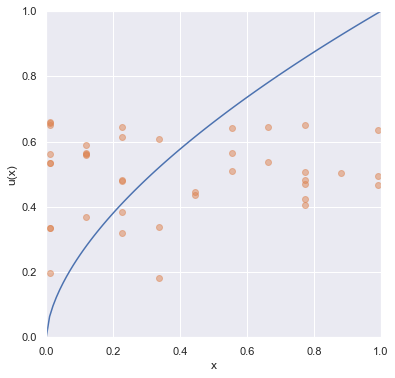

In [15]:
x_ = np.linspace(0, 1, 100)

# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot
ax.plot(x_, u(x_, true_alpha), label="True")

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((data["x"], np.mean(ex["u"], axis=0)))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()

## Model 2

## Generate data

In [16]:
np.random.seed(123)

In [17]:
def u(x, alpha):
    return x**(1 - alpha)

In [18]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]
task.reset_index(inplace=True, drop=True)

In [19]:
n_trial = len(task)

tau = 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

p_choice_1 = scipy.stats.norm.cdf(seu1 - seu0) # expit((seu1 - seu0)/tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice
task

,p0,x0,p1,x1,choice
0,0.696469,0.286139,0.226851,0.551315,1
1,0.480932,0.392118,0.343178,0.729050,0
2,0.438572,0.059678,0.398044,0.737995,0
3,0.634401,0.849432,0.724455,0.611024,1
4,0.426351,0.893389,0.944160,0.501837,0
...,...,...,...,...,...
500,0.116790,0.934562,0.280638,0.189423,0
501,0.924761,0.156253,0.298057,0.178112,1
502,0.167810,0.716638,0.535513,0.600545,1
503,0.521893,0.741486,0.875329,0.448498,0


In [20]:
n = 20 
selec = np.random.choice(np.arange(len(task)), size=n, replace=False)
p = np.concatenate((task.p0.values[selec], task.p1.values[selec])).T
x = np.concatenate((task.x0.values[selec], task.x1.values[selec])).T
y = task.choice.values[selec]
print("p", p)
print("x", x)
print("y", y)
data = {"p": p, "x": x, "y": y, "n_x": len(x), "n_y": len(y), "tau": tau}

p [0.82603597 0.96848212 0.17186536 0.35626065 0.06853658 0.54422271
 0.03084589 0.04503958 0.83418593 0.76939734 0.13185707 0.8535834
 0.92458903 0.47702151 0.43857224 0.65490077 0.11343058 0.93193215
 0.83790816 0.38332119 0.28330238 0.69871608 0.31919756 0.25139867
 0.10005466 0.03539336 0.52266599 0.65475264 0.6974982  0.10263526
 0.01675027 0.38865199 0.73774199 0.83090753 0.39804426 0.07215178
 0.48874966 0.20609573 0.38818585 0.2749956 ]
x [0.0213897  0.35821032 0.82005329 0.25581268 0.2075107  0.0222724
 0.49683023 0.67269851 0.40737468 0.57377411 0.02727462 0.16193532
 0.85489171 0.84685675 0.0596779  0.59684939 0.97224561 0.58217546
 0.92409405 0.28030394 0.53530624 0.462476   0.12566459 0.31745268
 0.00338436 0.23806151 0.28577249 0.10174605 0.95599989 0.69983407
 0.84605277 0.55418508 0.87354142 0.01735057 0.73799541 0.63289043
 0.06224207 0.71775756 0.93831583 0.91810036]
y [0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0]


In [21]:
model = """
data {
    int<lower=1> n_y;
    int y[n_y];
    int<lower=1> n_x;
    real x[n_x];
    real p[n_x];
    real tau;
}

transformed data {
}

parameters {
    real<lower=0> rho_u;
    real<lower=0> alpha_u;
    real<lower=0> rho_mu;
    real<lower=0> alpha_mu;
    vector[n_x] u;
    
    // vector[n_x] mu_u;
}

transformed parameters {
    matrix[n_x, n_x] K_u = cov_exp_quad(x, alpha_u, rho_u) + diag_matrix(rep_vector(1e-9, n_x));
    vector[n_x] mu_u = rep_vector(0, n_x);
    
    // matrix[n_x, n_x] K_mu = cov_exp_quad(x, alpha_mu, rho_mu) + diag_matrix(rep_vector(1e-9, n_x));
    // vector[n_x] mu_mu = rep_vector(0, n_x);
}

model {    
    vector[2] v;
    vector[2] p_choice;
    int c;
    real p_c;
    
    rho_u ~ normal(0, 3);
    alpha_u ~ normal(0, 1);
    
    //rho_mu ~ normal(0, 3);
    // alpha_mu ~ normal(0, 1);
    // mu_u ~ multi_normal(mu_mu, K_mu);
    
    u ~ multi_normal(mu_u, K_u);
        
    for (i in 1: n_y) {
        v[1] = p[i] * u[i];
        v[2] = p[i+n_y] * u[i+n_y];
        p_choice = softmax(v ./ tau);
        c = y[i]+1;
        p_c = p_choice[c];
        target += log(p_c);
    }
  
}
generated quantities {
}
"""

### Compile the model

In [22]:
# Put it to true if you edit the model
force_compilation = True

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'gp_utility_naive.pkl')

if not os.path.exists(bkp_file) or force_compilation is True:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26ab5d73ef8803b35d95d89a000127ed NOW.


### Sampling

In [23]:
# Put it to true if you want to do a new run
force_run = True

# Where to save backup
bkp_file = os.path.join(bkp_folder, 'gp_utility_naive_fit.pkl')

if not os.path.exists(bkp_file) or force_run is True:
    
    # Train the model and generate samples
    fit_stan = sm.sampling(data=data, 
                           iter=1000, chains=1, ) #algorithm="Fixed_param")
    
    # Save
    with open(bkp_file, 'wb') as f:
        pickle.dump(fit_stan, f)
else:
    # Load
    fit_stan = pickle.load(open(bkp_file, 'rb'))

fit_stan

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
<ipython-input-23-bfb2b62f9989>:15: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit_stan, f)



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_26ab5d73ef8803b35d95d89a000127ed.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

            mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
rho_u       0.87    0.32   0.75   0.25   0.35   0.53   1.05    3.07      6   1.58
alpha_u     0.34     0.1   0.38   0.06   0.12   0.18   0.37    1.48     15   1.21
rho_mu    1.0e65  1.0e65 5.5e65 5.1e13 2.2e26 4.7e41 6.4e54  1.9e66     30   1.03
alpha_mu   1.5e6   1.4e6  5.2e6  46.84 2119.3 8677.4  6.8e5   1.4e7     15   1.09
u[1]       -0.04  7.6e-3   0.02  -0.08  -0.05  -0.04  -0.02  1.9e-3      9   1.02
u[2]       -0.06  6.3e-3   0.02  -0.09  -0.07  -0.06  -0.05   -0.02      6   1.09
u[3]       -0.13  3.2e-3   0.01  -0.15  -0.13  -0.12  -0.12   -0.11     10    1.1
u[4]       -0.05  4.8e-3   0.01  -0.08  -0.06  -0.05  -0.05   -0.02      9   1.19
u[5]       -0.05  4.3e-3   0.01  -0.

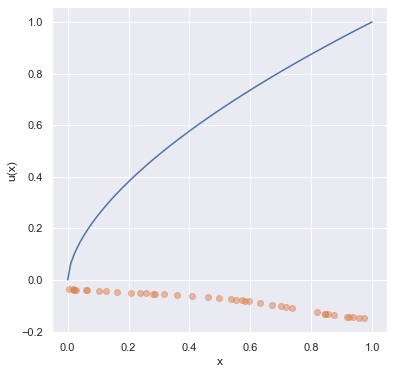

In [24]:
ex = fit_stan.extract()
len(data["x"])
len(np.mean(ex["u"], axis=0))

x_ = np.linspace(0, 1, 100)

# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
# x_min, x_max = 0, 1
# y_min, y_max = 0, 1

# Plot
ax.plot(x_, u(x_, true_alpha), label="True")

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)

coord = np.vstack((data["x"], np.mean(ex["u"], axis=0)))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()